In [128]:
# %
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from numpy.random import normal
import numpy_financial as npf
from utils import initialize_values, compound, plot_interval
from matplotlib.axes import Axes
from typing import List, Tuple
# %

This notebook shows how to use Monte Carlo simulations to compare the performance of a real estate (RE) and ETF portfolio. 

Let's start by defining some generic parameters

In [129]:
##### GENERAL
INITIAL_CAPITAL = 100_000
INVESTMENT_HORIZON = 30
N_SAMPLE = 10_000
INFLATION_MEAN = 1.4/100
INFLATION_STD = 0.9/100

#### charts parameters
PLOT_PERCENTILES = [0.1, 0.25, 0.5, 0.75, 0.9]
SP_FIGSIZE = [12.12, 4.]

We will consider 3 quantities as random variables, namely
- the yearly RE appreciation
- the yearly ETF returns
- the inflation

We will use pandas dataframes to store those quantities (and the quantities that derive from them). The index will store the year while the columns will store the scenarios. We will therefore have dataframes of shapes (INVESTMENT_HORIZON, N_SAMPLE)

In [130]:
mc_shapes = [INVESTMENT_HORIZON, N_SAMPLE]
inflation = pd.DataFrame(normal(INFLATION_MEAN, INFLATION_STD, mc_shapes))
inflation.iloc[0, :] = 0 #we dont want to index price on the first year so we manually set the inflation to 0

here is how the inflation dataframe looks like

In [131]:
inflation.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.021764,0.016046,0.028477,0.015066,0.021828,0.021003,0.018158,0.022711,-0.001325,0.023803,...,0.004820,-0.009268,0.027327,0.003747,0.028729,0.025820,0.014546,-0.004525,0.002422,0.024861
2,0.008296,0.000585,0.018618,0.021003,0.002458,0.009446,0.012075,0.004539,0.027587,0.008879,...,0.011741,0.022468,0.017372,0.000204,0.006821,0.011016,0.023644,0.005450,-0.004604,0.009502
3,-0.005187,0.015186,0.007213,0.008096,0.013265,0.009066,0.026080,0.026928,0.035440,0.004647,...,-0.002728,0.013023,0.005188,-0.000920,0.016660,0.018148,-0.006054,0.029377,0.022768,0.016808
4,0.010115,0.006519,0.004141,0.020874,0.014092,0.019548,0.014173,0.035183,0.005314,0.006816,...,0.007048,0.007327,0.011069,0.010664,0.009654,0.029994,0.014651,0.018312,0.006019,0.012620


Let's now define a bunch of parameters related to RE.

**Important Note:** the time unit used in this analysis is the year. Since mortgages are generally repaid on a monthly basis, we will need to do some units conversions from months to years. So dont be surprised if you see many `*12`or things like that

In [132]:
##### REAL ESTATE 
DOWN_PAYMENT = 20/100 
CLOSING_COST = 10/100
YEARLY_INTEREST_RATE = 1.5/100
LOAN_TERM = 25
RE_APPRECIATION_MEAN = 3.5/100
RE_APPRECIATION_STD = 8/100
RENTAL_YIELD = 5/100
VACANCY_RATE = 5/100
PROPERTY_TAX = 0.5/100
RENTAL_INCOME_TAX = 10/100
MAINTENANCE_COST = 1/100
MANAGEMENT_FEE = 0.1/100

we need to initialize a few variables (most of them will be dataframes of size [INVESTMENT_HORIZON, N_SAMPLE]). 

In [133]:
##### REAL ESTATE 
initial_re_value = INITIAL_CAPITAL / (DOWN_PAYMENT + CLOSING_COST)
re_values = initialize_values(initial_re_value, mc_shapes)
re_invested_amounts = initialize_values(INITIAL_CAPITAL, mc_shapes)

for example the property value `re_values` at the first year is simply equal to the initial value of the home. We leave the remaining values to 0, they will be updated down the path based on the Monte Carlo simulation


In [134]:
re_values.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,333333.333333,333333.333333,333333.333333,333333.333333,333333.333333,333333.333333,333333.333333,333333.333333,333333.333333,333333.333333,...,333333.333333,333333.333333,333333.333333,333333.333333,333333.333333,333333.333333,333333.333333,333333.333333,333333.333333,333333.333333
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


I susbstract the downmpayment from the initial property price to estimate how much shall be borrowed from the bank (`loan`).
By taking into account the interest rate and the duration of the mortgage, we compute the amount that has to be repaid on the yearly basis to cover the mortgage.
[Numpy financial](https://numpy.org/numpy-financial/latest/) has actually a convenient built-in function `pmt` to do that.

In [135]:
loan = initial_re_value *(1 - DOWN_PAYMENT) #this is what will be borrowed from the bank
monthly_interest_rate = (1 + YEARLY_INTEREST_RATE)**(1/12) - 1
yearly_loan_repayments = pd.DataFrame(np.zeros(mc_shapes))
yearly_loan_repayments.iloc[:LOAN_TERM] = -npf.pmt(monthly_interest_rate, LOAN_TERM * 12, loan) * 12

`yearly_loan_repayments` includes both the principal and the interests of your mortgage. We also need to know what is the amount of loan that needs to be repaid at a certain point. Indeed, if you sell the property before the end of your loan, you will need to know what you still owe to the bank to be able to estimate what will go into your pocket. This quantity is stored in `yearly_pmt`, and you can see that is is gradually decreasing

In [136]:
monthly_pmt = npf.ppmt(monthly_interest_rate, np.arange(LOAN_TERM *12)+1, LOAN_TERM * 12, loan)
yearly_pmt = pd.Series([-np.sum(monthly_pmt[:-ii*12]) if ii <= LOAN_TERM else 0 for ii in range(INVESTMENT_HORIZON)])
yearly_pmt.iloc[0] = loan
yearly_pmt

0     266666.666667
1     253986.613096
2     241493.949479
3     229185.906507
4     217059.755795
5     205112.809281
6     193342.418627
7     181745.974633
8     170320.906658
9     159064.682053
10    147974.805594
11    137048.818936
12    126284.300060
13    115678.862744
14    105230.156029
15     94935.863699
16     84793.703768
17     74801.427974
18     64956.821280
19     55257.701385
20     45701.918236
21     36287.353558
22     27011.920378
23     17873.562565
24      8870.254375
25        -0.000000
26         0.000000
27         0.000000
28         0.000000
29         0.000000
dtype: float64

People often think that, after the first down payment, your rental income will fully cover your investment. This is a common misconception. Most of the time, your rental income will cover your mortgage repayment. But there are many side costs such as property maintenance costs, rental income, and property taxes or rental vacancy. These costs are often neglected, and can ultimately force you to pour additional money.
Cash flow is a key concept in real estate to assess if at a certain point in time, your investment is sucking capital (negative cash flow) or if it is actually generating money (positive cash flow).
The cash flow is simply the difference between the income (basically the rent) and all the expenses.

It is important to index both the rent and the cost based on the inflation. It is pretty easy to do in practice since `inflation` is a dataframe, we just need to compound the effect with `cumprod`. 

In [137]:
yearly_rent = (RENTAL_YIELD * initial_re_value) * (1 - VACANCY_RATE - RENTAL_INCOME_TAX)
yearly_cost = (PROPERTY_TAX + MAINTENANCE_COST + MANAGEMENT_FEE) * initial_re_value
yearly_cash_flow = ((yearly_rent - yearly_cost)* (1 + inflation).cumprod()) - yearly_loan_repayments

Below is helper function that will turn useful to visualize the evolution of the different quantities

In [138]:
def plot_interval(df: pd.DataFrame, ax: Axes, color: str, 
                  fills: List[Tuple[str, str]] = [("10%", "90%"), ("25%", "75%")], 
                  alphas: List[float] = [0.2, 0.5], 
                  lines: List[str] = ["50%", "mean"], 
                  linestyles: List[str] = ["solid", "dashed"], 
                  legend_loc: int = 2,
                  legend_prefix: str = "",
                  offset_xticks: bool = True) -> Axes:

    if offset_xticks:
        x_ticks = df.index + 1
    for ii, fill in enumerate(fills):
        label = "-".join(fill)
        ax.fill_between(x_ticks, df[fill[0]], df[fill[1]], color=color, alpha=alphas[ii], label=legend_prefix + label)
    for ii, line in enumerate(lines):
        ax.plot(x_ticks, df[line], color=color, linestyle=linestyles[ii], label=legend_prefix + line)
    ax.legend(loc=legend_loc)
    return ax


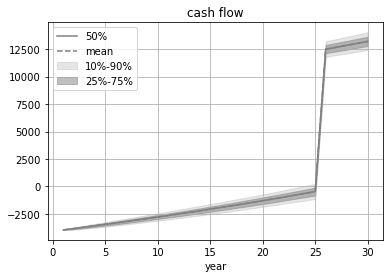

In [139]:
yearly_cash_flow_summary = yearly_cash_flow.T.describe(percentiles=PLOT_PERCENTILES).T
fig, ax1 = plt.subplots()
ax1 = plot_interval(yearly_cash_flow_summary, ax1, color="grey")
ax1.set_title("cash flow")
ax1.set_xlabel("year")
ax1.grid()


Lets now look at the appreciation of the property. Scenarios are generated by compounding the yearly returns (normal distributions assumed). 
I created a small function to simulate the growth of a portfolio



In [140]:
def compound(amounts: pd.DataFrame, returns: pd.DataFrame) -> pd.DataFrame:
    """ replicate the evolution of a portfolio

    Parameters
    ----------
    amounts : pd.DataFrame
        amount invested on each time period
    returns : pd.DataFrame
        asset performance on each time period

    Returns
    -------
    pd.DataFrame

    """
    compounded_values = returns.copy()
    compounded_values.iloc[0, :] = amounts.iloc[0, :]
    for ii in range(1, len(amounts)):
        compounded_values.iloc[ii, :] = (amounts.iloc[ii] + 
                                    compounded_values.iloc[ii-1]*returns.iloc[ii-1].add(1))
    return compounded_values

In case of RE, the amount that gets compounded is simply the initial value of the property

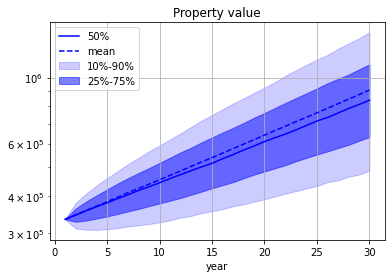

In [141]:
re_returns = pd.DataFrame(normal(RE_APPRECIATION_MEAN, RE_APPRECIATION_STD, mc_shapes))

re_values = compound(re_values, re_returns)

fig, ax1 = plt.subplots()
ax1 = plot_interval(re_values.T.describe(percentiles=PLOT_PERCENTILES).T, ax1, color="blue")
ax1.set_ylabel("")
ax1.set_xlabel("year")
ax1.set_title("Property value")
ax1.set_yscale("log")
ax1.grid()
plt.show(block=False)

To estimate the RE portfolio value (i.e. what we will get if we sell the property at some points) we need to  
subtract what remains to be paid to the bank 
add the accumulated positive cash flow obtained from the rent (if any)

In [142]:
re_ptf = (re_values
              .add(yearly_cash_flow.where(yearly_cash_flow > 0, other=0).cumsum())
              .sub(yearly_pmt, axis=0)
              )
re_summary = re_ptf.T.describe(percentiles=PLOT_PERCENTILES).T


It is really important to take into account the negative part of the cash flow to estimate the total cost of this investment. 
Note that I shift negative part of the cash flow on purpose when computing `re_invested_amounts`. I do this because, when comparing with the ETF, I will need to make sure that the invested amounts are similar. And I consider that the negative cashflow accumulated over year i will be invested on the first day of year i+1

In [143]:
re_invested_amounts = re_invested_amounts - yearly_cash_flow.where(yearly_cash_flow < 0, other=0).shift().fillna(0)
total_re_invested_amounts_summary = re_invested_amounts.cumsum().T.describe(percentiles=PLOT_PERCENTILES).T

We can now visualize the RE portfolio value and the total cost of the asset side by side

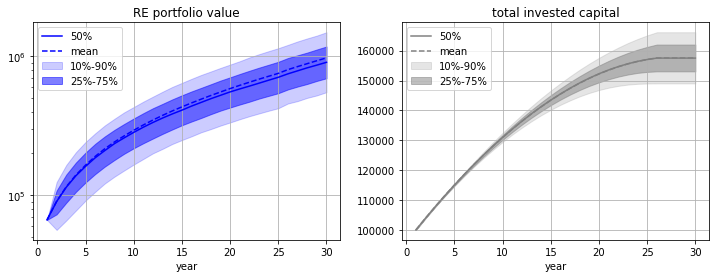

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=SP_FIGSIZE)
ax1 = plot_interval(re_summary, ax1, color="blue")
ax1.title.set_text("RE portfolio value")
ax1.set_xlabel("year")
ax1.set_yscale("log")
ax1.grid()
ax2 = plot_interval(total_re_invested_amounts_summary, ax2, color="grey")
ax2.title.set_text("total invested capital")
ax2.set_xlabel("year")
ax2.grid()
plt.show(block=False)

Time to discuss the ETF. Lets first define the simulation parameters

In [145]:
##### ETF
ETF_RETURN_MEAN = 0.10
ETF_RETURN_STD = 0.16
BROKER_BUYING_FEE = 5
ETF_YEARLY_COST = 0.25/100

Estimating the ETF portfolio values is actually much simpler. We just need to 
1. generate the returns from which we need to subtract the ETF yearly cost
2. define the amount of capital used to buy the ETF (ie initial capital on the first year, and the RE negative cashflow after that)
3. subtract the broker fee if an order is passed (ie if the invested amounts > 0)
4. compound the invested amounts using the returns defined at step 1

In [146]:
##### ETF
etf_returns = pd.DataFrame(normal(ETF_RETURN_MEAN, ETF_RETURN_STD, mc_shapes)) - ETF_YEARLY_COST
etf_invested_amounts = pd.DataFrame(np.zeros(mc_shapes))
etf_invested_amounts.iloc[0] = INITIAL_CAPITAL
etf_invested_amounts = etf_invested_amounts - yearly_cash_flow.where(yearly_cash_flow < 0, other=0).shift().fillna(0)
etf_invested_amounts = etf_invested_amounts.where(etf_invested_amounts ==0, other = etf_invested_amounts - BROKER_BUYING_FEE)
etf_values = compound(etf_invested_amounts, etf_returns)

In [147]:
etf_summary = etf_values.T.describe(percentiles=PLOT_PERCENTILES).T

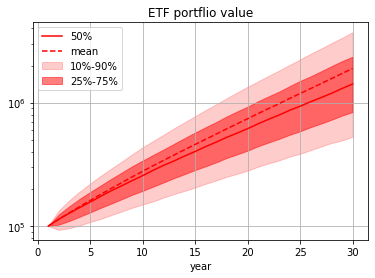

In [148]:
etf_summary = etf_values.T.describe(percentiles=PLOT_PERCENTILES).T
fig, ax1 = plt.subplots()
ax1 = plot_interval(etf_summary, ax1, color="red")
ax1.set_ylabel("")
ax1.set_xlabel("year")
ax1.set_title("ETF portflio value")
ax1.set_yscale("log")
ax1.grid()
plt.show(block=False)

We can now compare the evolution of the two portfolios and their total returns at year 30

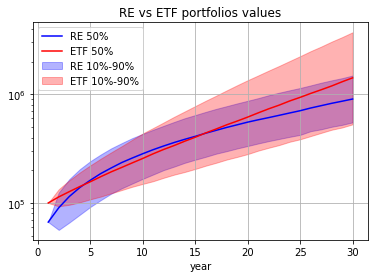

In [149]:
fig, ax1 = plt.subplots()
ax1 = plot_interval(re_summary, ax1, color="blue", fills=[("10%", "90%")], alphas=[0.3], lines=["50%"], linestyles=["solid"], legend_prefix="RE ")
ax1 = plot_interval(etf_summary, ax1, color="red", fills=[("10%", "90%")], alphas=[0.3], lines=["50%"], linestyles=["solid"], legend_prefix="ETF ")
ax1.set_xlabel("year")
ax1.set_title("RE vs ETF portfolios values")
ax1.set_yscale("log")
ax1.grid()
plt.show(block=False)

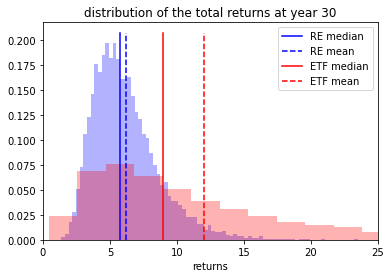

In [150]:
fig, ax1 = plt.subplots()
re_ptf_returns = (re_ptf.iloc[-1]/re_invested_amounts.cumsum().iloc[-1])
etf_ptf_returns = (etf_values.iloc[-1]/re_invested_amounts.cumsum().iloc[-1])
re_ptf_returns.hist(ax=ax1, bins=100, color="b", density=1, alpha=0.3)
etf_ptf_returns.hist(ax=ax1, bins=100, color="r", alpha=0.3, density=1)
ax1.set_xlim([0, 25])
ylims = ax1.get_ylim()
ax1.plot([re_ptf_returns.median()]*2, ylims, color="b", label="RE median")
ax1.plot([re_ptf_returns.mean()]*2, ylims, color="b", linestyle="--", label="RE mean")
ax1.plot([etf_ptf_returns.median()]*2, ylims, color="r", label="ETF median")
ax1.plot([etf_ptf_returns.mean()]*2, ylims, color="r", linestyle="--", label="ETF mean")
ax1.title.set_text("distribution of the total returns at year 30")
ax1.set_xlabel("returns")
ax1.legend()
ax1.grid()
plt.show(block=False)